In [1]:
import os, sys
cwd = os.getcwd()

api_path_сifar = os.path.join(cwd, '..', 'tools', 'cifar10_utils')
api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')
api_path_sngan_utils = os.path.join(cwd, '..', 'tools', 'sngan_cifar10_utils')

models_cifar_scratch_path = os.path.join(cwd, '..', 'models', 'models_cifar10')

sys.path.append(api_path_сifar)
sys.path.append(api_path_sampling)
sys.path.append(api_path_gan_metrics)
sys.path.append(api_path_sngan_utils)

In [2]:
import numpy as np
import time
import random
import glob
import importlib
from tqdm import tqdm
from matplotlib import pyplot as plt
import easydict


import torch, torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from distributions import IndependentNormal
import torchvision.transforms as transforms

from functools import partial

from dataloader import get_loader

from params_cifar10 import args
from general_utils import to_var, DotDict, to_np

from metrics_utils import (calculate_images_statistics, z_transform, 
                           load_dict_stats, plot_scores_dynamics)

from mh_sampling import mh_sampling, mh_sampling_from_scratch
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          tempered_transitions_sampling,
                          gan_energy,
                          gan_energy_tempering,
                          report_energy, 
                          report_mean_discriminator)

from sir_ais_sampling import (sir_independent_sampling,
                              sir_correlated_sampling,
                              cisir_adaptive_sampling,
                              sir_independent_mala_sampling)

from metrics import inception_score
from dataloader import GenDataset, LatentFixDataset

import source.models.sngan as models
import torchvision

In [3]:
net_G_models = {
    'res32': models.ResGenerator32,
    'res48': models.ResGenerator48,
    'cnn32': models.Generator32,
    'cnn48': models.Generator48,
}

net_D_models = {
    'res32': models.ResDiscriminator32,
    'res48': models.ResDiscriminator48,
    'cnn32': models.Discriminator32,
    'cnn48': models.Discriminator48,
}

In [4]:
FLAGS = easydict.EasyDict({
    'arch': 'cnn32',
    'z_dim': 100
})

path_to_sngan = os.path.join(models_cifar_scratch_path, "model.pt")

## Download model

In [5]:
args.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = args.device

net_G = net_G_models[FLAGS.arch](FLAGS.z_dim).to(device)

net_G.load_state_dict(torch.load(path_to_sngan)['net_G'])
net_G.eval()

Generator32(
  (linear): Linear(in_features=100, out_features=8192, bias=True)
  (main): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [7]:
net_D = net_D_models[FLAGS.arch]().to(device)

net_D.load_state_dict(torch.load(path_to_sngan)['net_D'])
net_D.eval()

Discriminator32(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.1, inplace=True)
    (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): LeakyReLU(neg

In [20]:
batch_size = 16
z = torch.randn(batch_size, FLAGS.z_dim).to(device)
x = net_G(z).detach().cpu()

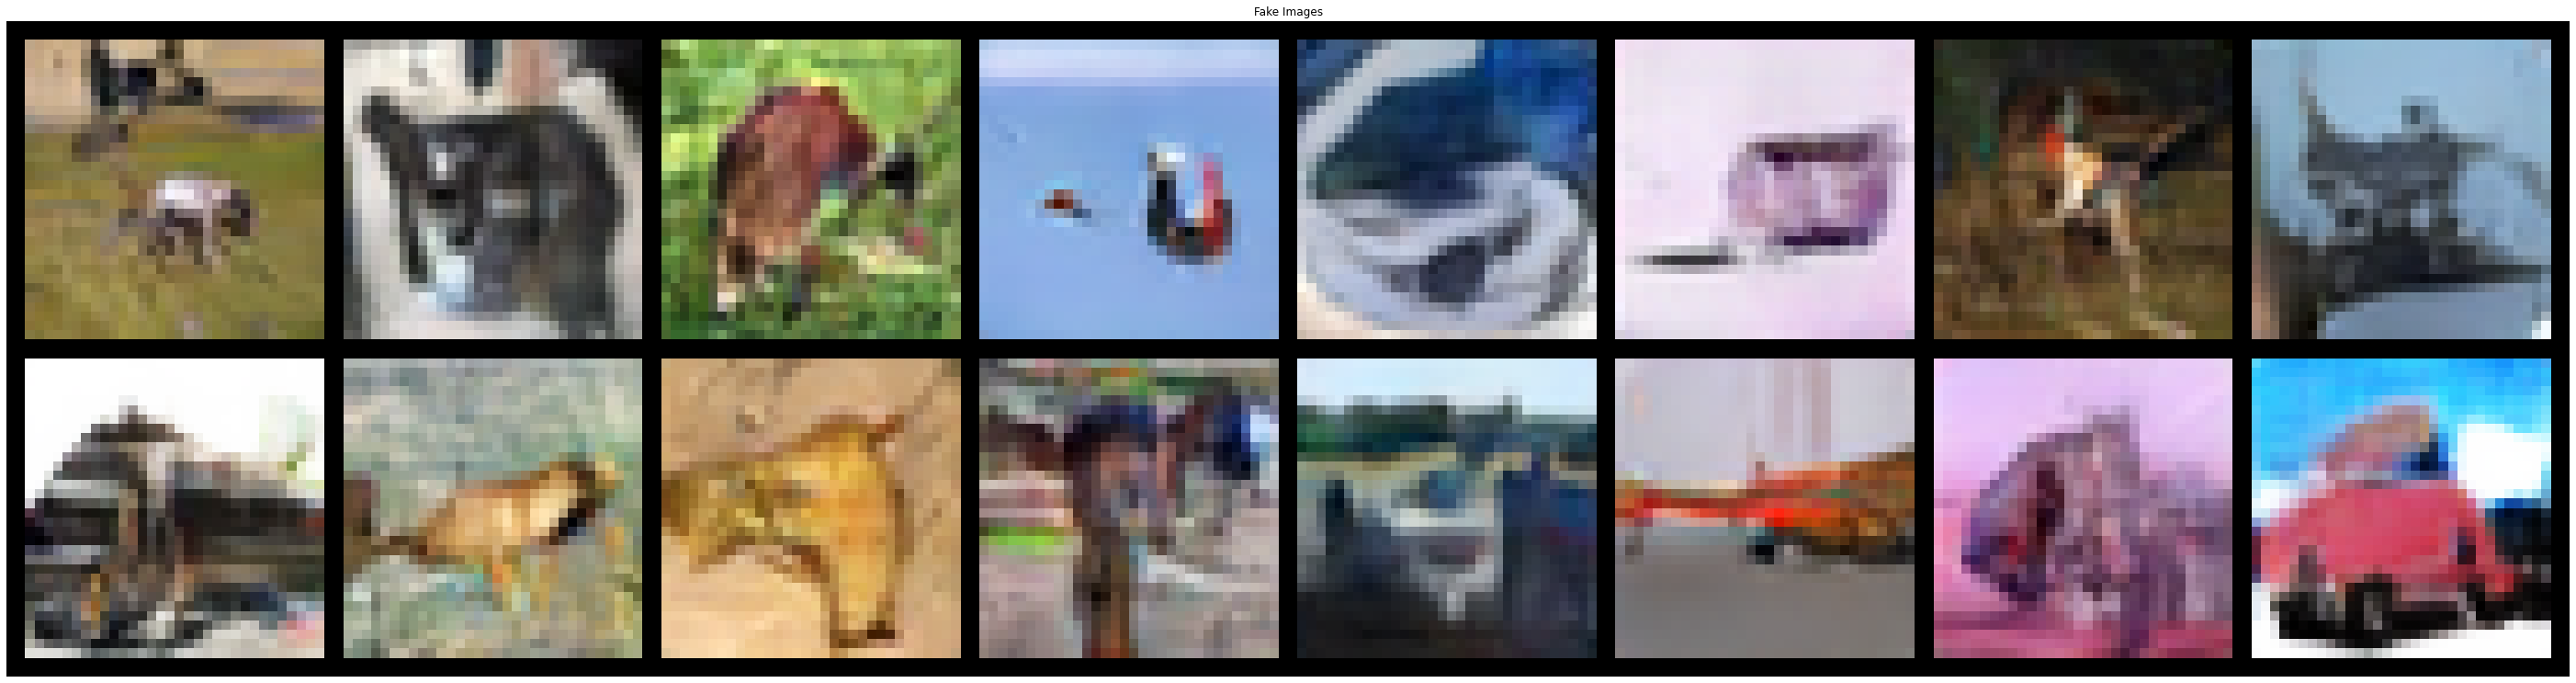

In [21]:
grid = torchvision.utils.make_grid(x, scale_each=True, normalize=True)
plt.figure(figsize=(50, 150))
plt.title("Fake Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [25]:
net_D(x.to(device))

tensor([[ 0.0485],
        [ 0.1133],
        [ 0.0546],
        [ 0.1749],
        [ 0.3335],
        [-0.6143],
        [-0.0029],
        [ 0.1645],
        [ 0.2149],
        [-0.0058],
        [-0.0025],
        [-0.2532],
        [ 0.2651],
        [ 0.1341],
        [-0.2963],
        [ 0.0698]], device='cuda:1', grad_fn=<MmBackward>)

In [26]:
net_D(x.to(device)).sigmoid()

tensor([[0.5121],
        [0.5283],
        [0.5136],
        [0.5436],
        [0.5826],
        [0.3511],
        [0.4993],
        [0.5410],
        [0.5535],
        [0.4986],
        [0.4994],
        [0.4370],
        [0.5659],
        [0.5335],
        [0.4265],
        [0.5174]], device='cuda:1', grad_fn=<SigmoidBackward>)

In [6]:
n_steps = 601

grad_step = 0.02
eps_scale = (2 * grad_step) ** 0.5
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
path_to_save = path_to_save_np
method_name = f'ula_sngan_resnet_stats_{n_steps}_steps_step_{grad_step}_eps_{eps_scale}'
dataset = "cifar10"
dict_results_ula = load_dict_stats(method_name, path_to_save)

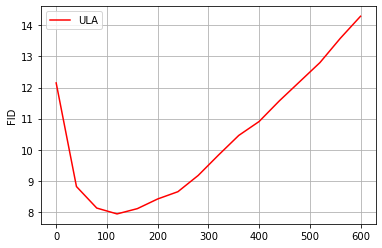

In [7]:
plt.plot([i*40 for i in range(len(dict_results_ula['fid_scores_mean_train']))],
          dict_results_ula['fid_scores_mean_train'], label = fr"ULA", color="r")
plt.legend()
plt.grid(True)
# plt.xlabel("MCMC iteration")
plt.ylabel("FID")
plt.show()

## Energy

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

path_to_sngan = os.path.join(models_cifar_scratch_path, "model.pt")

G = net_G_models[FLAGS.arch](FLAGS.z_dim).to(device)
G.load_state_dict(torch.load(path_to_sngan)['net_G'])
G.eval()

D = net_D_models[FLAGS.arch]().to(device)

D.load_state_dict(torch.load(path_to_sngan)['net_D'])
D.eval()

G.z_dim = FLAGS.z_dim
G.device = device
z_dim = FLAGS.z_dim

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

In [ ]:
log_prob = True
normalize_to_0_1 = True

target_gan = partial(gan_energy,
                     generator=G,
                     discriminator=D,
                     proposal=proposal,
                     normalize_to_0_1=normalize_to_0_1,
                     log_prob=log_prob)

log_prob = False
normalize_to_0_1 = True

target_energy = partial(gan_energy,
                         generator = G, 
                         discriminator = D, 
                         proposal = proposal,
                         normalize_to_0_1 = normalize_to_0_1,
                         log_prob = log_prob)

In [8]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 200
n = 1000
n_steps = 601

grad_step = 0.01
eps_scale = (2 * grad_step) ** 0.5

use_noise = True

method_name = 'ula_sngan_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_nsteps_{n_steps}_step_{grad_step}_eps_{eps_scale}_use_noise_{use_noise}'
every_step = 40
continue_z = None

In [14]:
z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z, n_steps, grad_step, eps_scale,
                                  use_noise)

 20%|██        | 1/5 [00:31<02:05, 31.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_nsteps_601_step_0.001_eps_0.044721359549995794_use_noise_True_batch_num_0.npy was saved, file shape = (16, 200, 100)


 40%|████      | 2/5 [01:03<01:34, 31.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_nsteps_601_step_0.001_eps_0.044721359549995794_use_noise_True_batch_num_200.npy was saved, file shape = (16, 200, 100)


 60%|██████    | 3/5 [01:35<01:03, 31.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_nsteps_601_step_0.001_eps_0.044721359549995794_use_noise_True_batch_num_400.npy was saved, file shape = (16, 200, 100)


 80%|████████  | 4/5 [02:09<00:32, 32.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_nsteps_601_step_0.001_eps_0.044721359549995794_use_noise_True_batch_num_600.npy was saved, file shape = (16, 200, 100)


100%|██████████| 5/5 [02:42<00:00, 32.50s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_nsteps_601_step_0.001_eps_0.044721359549995794_use_noise_True_batch_num_800.npy was saved, file shape = (16, 200, 100)


In [22]:
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

n = 1000
batchsize = 200
num_bs = n // batchsize

100%|██████████| 5/5 [00:00<00:00, 2891.03it/s]


In [23]:
load_np.shape

(16, 1000, 100)

In [16]:
ula_mean, std_mean = report_energy(load_np, target_energy, num_bs, batchsize, device)

  6%|▋         | 1/16 [00:00<00:02,  7.16it/s]

iter = 0
number of energy samples = 1000
mean = 141.57618713378906
std = 6.941837310791016
------------
iter = 1


 19%|█▉        | 3/16 [00:00<00:01,  7.74it/s]

number of energy samples = 1000
mean = 141.6167449951172
std = 6.8871049880981445
------------
iter = 2
number of energy samples = 1000
mean = 141.5428924560547
std = 6.869114398956299
------------
iter = 3


 31%|███▏      | 5/16 [00:00<00:01,  8.29it/s]

number of energy samples = 1000
mean = 141.564208984375
std = 6.833950996398926
------------
iter = 4
number of energy samples = 1000
mean = 141.5693817138672
std = 6.922618389129639
------------
iter = 5


 44%|████▍     | 7/16 [00:00<00:01,  8.57it/s]

number of energy samples = 1000
mean = 141.59971618652344
std = 7.045480251312256
------------
iter = 6
number of energy samples = 1000
mean = 141.56143188476562
std = 7.013923645019531
------------
iter = 7


 56%|█████▋    | 9/16 [00:01<00:00,  8.71it/s]

number of energy samples = 1000
mean = 141.54434204101562
std = 6.948049068450928
------------
iter = 8
number of energy samples = 1000
mean = 141.54547119140625
std = 6.887993812561035
------------
iter = 9


 69%|██████▉   | 11/16 [00:01<00:00,  8.76it/s]

number of energy samples = 1000
mean = 141.79437255859375
std = 7.066688060760498
------------
iter = 10
number of energy samples = 1000
mean = 141.63604736328125
std = 7.068658351898193
------------
iter = 11


 81%|████████▏ | 13/16 [00:01<00:00,  8.81it/s]

number of energy samples = 1000
mean = 141.65957641601562
std = 6.982520580291748
------------
iter = 12
number of energy samples = 1000
mean = 141.55992126464844
std = 6.967651844024658
------------
iter = 13


 94%|█████████▍| 15/16 [00:01<00:00,  8.81it/s]

number of energy samples = 1000
mean = 141.72769165039062
std = 6.881908416748047
------------
iter = 14
number of energy samples = 1000
mean = 141.83949279785156
std = 6.7959513664245605
------------
iter = 15


100%|██████████| 16/16 [00:01<00:00,  8.65it/s]

number of energy samples = 1000
mean = 141.86807250976562
std = 6.864884853363037
------------


In [12]:
z_transform = lambda x: x
use_sigmoid = True
mean_discr_val, std_discr_val = report_mean_discriminator(load_np, G, D, z_transform, 
                                                          num_bs, batchsize, device, 
                                                          use_sigmoid=use_sigmoid)

  6%|▋         | 1/16 [00:00<00:02,  6.88it/s]

iter = 0
number of energy samples = 1000
mean = 0.5029714703559875
std = 0.061125773936510086
------------
iter = 1


 19%|█▉        | 3/16 [00:00<00:01,  7.77it/s]

number of energy samples = 1000
mean = 0.5112537741661072
std = 0.06480196863412857
------------
iter = 2
number of energy samples = 1000
mean = 0.512615442276001
std = 0.06943948566913605
------------
iter = 3


 31%|███▏      | 5/16 [00:00<00:01,  8.40it/s]

number of energy samples = 1000
mean = 0.5151352286338806
std = 0.06988409906625748
------------
iter = 4
number of energy samples = 1000
mean = 0.5160415172576904
std = 0.06776811927556992
------------
iter = 5


 44%|████▍     | 7/16 [00:00<00:01,  8.75it/s]

number of energy samples = 1000
mean = 0.5169346332550049
std = 0.07301807403564453
------------
iter = 6
number of energy samples = 1000
mean = 0.519384503364563
std = 0.0714033767580986
------------
iter = 7


 56%|█████▋    | 9/16 [00:01<00:00,  8.92it/s]

number of energy samples = 1000
mean = 0.5206618905067444
std = 0.07226356118917465
------------
iter = 8
number of energy samples = 1000
mean = 0.5182867646217346
std = 0.06980642676353455
------------
iter = 9


 69%|██████▉   | 11/16 [00:01<00:00,  8.97it/s]

number of energy samples = 1000
mean = 0.5201107859611511
std = 0.06878313422203064
------------
iter = 10
number of energy samples = 1000
mean = 0.5206559300422668
std = 0.06930982321500778
------------
iter = 11


 81%|████████▏ | 13/16 [00:01<00:00,  9.03it/s]

number of energy samples = 1000
mean = 0.5193929672241211
std = 0.07198438048362732
------------
iter = 12
number of energy samples = 1000
mean = 0.5231857895851135
std = 0.0720687061548233
------------
iter = 13


 94%|█████████▍| 15/16 [00:01<00:00,  9.06it/s]

number of energy samples = 1000
mean = 0.5209752321243286
std = 0.06862544268369675
------------
iter = 14
number of energy samples = 1000
mean = 0.5219969153404236
std = 0.07213860750198364
------------
iter = 15


100%|██████████| 16/16 [00:01<00:00,  8.87it/s]

number of energy samples = 1000
mean = 0.523271381855011
std = 0.07315070182085037
------------


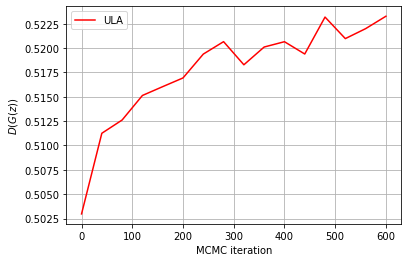

In [13]:
plt.plot([i*40 for i in range(len(mean_discr_val))], mean_discr_val, label = "ULA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel(fr"$D(G(z))$")
plt.grid()
plt.legend()
plt.show()

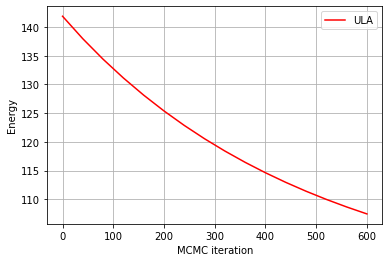

In [13]:
plt.plot([i*40 for i in range(len(ula_mean))], ula_mean, label = "ULA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel("Energy")
plt.grid()
plt.legend()
plt.show()

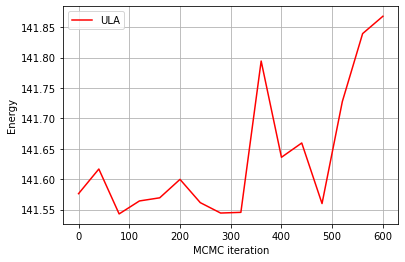

In [17]:
plt.plot([i*40 for i in range(len(ula_mean))], ula_mean, label = "ULA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel("Energy")
plt.grid()
plt.legend()
plt.show()

In [8]:
T = 10.0

log_prob = True
normalize_to_0_1 = True

tempering_target_gan = partial(gan_energy_tempering,
                     generator=G,
                     discriminator=D,
                     proposal=proposal,
                     normalize_to_0_1=normalize_to_0_1,
                     log_prob=log_prob,
                     T=T)

log_prob = False
normalize_to_0_1 = True


tempering_target_energy = partial(gan_energy_tempering,
                         generator = G, 
                         discriminator = D, 
                         proposal = proposal,
                         normalize_to_0_1 = normalize_to_0_1,
                         log_prob = log_prob,
                         T=T)

In [9]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 100
n = 1000
n_steps = 601

grad_step = 0.01
eps_scale = (2 * grad_step) ** 0.5

use_noise = True

method_name = f'ula_sngan_cifar_recalc_tempering_{T}'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_nsteps_{n_steps}_step_{grad_step}_eps_{eps_scale}_use_noise_{use_noise}'
every_step = 40
continue_z = None

In [10]:
z_last_np, zs = langevin_sampling(tempering_target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z, n_steps, grad_step, eps_scale,
                                  use_noise)

 10%|█         | 1/10 [00:35<05:15, 35.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_tempering_10.0_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_0.npy was saved, file shape = (16, 100, 100)


 20%|██        | 2/10 [01:09<04:39, 34.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_tempering_10.0_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_100.npy was saved, file shape = (16, 100, 100)


 30%|███       | 3/10 [01:44<04:03, 34.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_tempering_10.0_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_200.npy was saved, file shape = (16, 100, 100)


 40%|████      | 4/10 [02:18<03:28, 34.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_tempering_10.0_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_300.npy was saved, file shape = (16, 100, 100)


 50%|█████     | 5/10 [02:53<02:53, 34.68s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_tempering_10.0_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_400.npy was saved, file shape = (16, 100, 100)


 60%|██████    | 6/10 [03:27<02:18, 34.64s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_tempering_10.0_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_500.npy was saved, file shape = (16, 100, 100)


 70%|███████   | 7/10 [04:02<01:43, 34.62s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_tempering_10.0_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_600.npy was saved, file shape = (16, 100, 100)


 80%|████████  | 8/10 [04:36<01:09, 34.61s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_tempering_10.0_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_700.npy was saved, file shape = (16, 100, 100)


 90%|█████████ | 9/10 [05:11<00:34, 34.61s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_tempering_10.0_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_800.npy was saved, file shape = (16, 100, 100)


100%|██████████| 10/10 [05:46<00:00, 34.62s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_cifar_recalc_tempering_10.0_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_900.npy was saved, file shape = (16, 100, 100)


In [11]:
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

n = 1000
batchsize = 100
num_bs = n // batchsize

100%|██████████| 10/10 [00:00<00:00, 3377.06it/s]


In [13]:
log_prob = False
normalize_to_0_1 = True

target_energy = partial(gan_energy,
                         generator = G, 
                         discriminator = D, 
                         proposal = proposal,
                         normalize_to_0_1 = normalize_to_0_1,
                         log_prob = log_prob)

In [17]:
ula_mean, std_mean = report_energy(load_np, target_energy, num_bs, batchsize, device)

  0%|          | 0/16 [00:00<?, ?it/s]

iter = 0


  6%|▋         | 1/16 [00:00<00:04,  3.35it/s]

number of energy samples = 1000
mean = 141.6397247314453
std = 7.0129594802856445
------------
iter = 1


 12%|█▎        | 2/16 [00:00<00:04,  3.34it/s]

number of energy samples = 1000
mean = 97.21489715576172
std = 0.7440405488014221
------------
iter = 2


 19%|█▉        | 3/16 [00:00<00:03,  3.34it/s]

number of energy samples = 1000
mean = 97.20036315917969
std = 0.7421139478683472
------------
iter = 3


 25%|██▌       | 4/16 [00:01<00:03,  3.34it/s]

number of energy samples = 1000
mean = 97.13306427001953
std = 0.7426393032073975
------------
iter = 4


 31%|███▏      | 5/16 [00:01<00:03,  3.33it/s]

number of energy samples = 1000
mean = 97.23138427734375
std = 0.7603744268417358
------------
iter = 5


 38%|███▊      | 6/16 [00:01<00:03,  3.32it/s]

number of energy samples = 1000
mean = 97.2076187133789
std = 0.7216581106185913
------------
iter = 6


 44%|████▍     | 7/16 [00:02<00:02,  3.33it/s]

number of energy samples = 1000
mean = 97.19959259033203
std = 0.740278959274292
------------
iter = 7


 50%|█████     | 8/16 [00:02<00:02,  3.32it/s]

number of energy samples = 1000
mean = 97.16096496582031
std = 0.7418732643127441
------------
iter = 8


 56%|█████▋    | 9/16 [00:02<00:02,  3.32it/s]

number of energy samples = 1000
mean = 97.2118148803711
std = 0.7678443789482117
------------
iter = 9


 62%|██████▎   | 10/16 [00:03<00:01,  3.32it/s]

number of energy samples = 1000
mean = 97.1954345703125
std = 0.7412859797477722
------------
iter = 10


 69%|██████▉   | 11/16 [00:03<00:01,  3.31it/s]

number of energy samples = 1000
mean = 97.20182037353516
std = 0.7614750266075134
------------
iter = 11


 75%|███████▌  | 12/16 [00:03<00:01,  3.32it/s]

number of energy samples = 1000
mean = 97.21600341796875
std = 0.7540574073791504
------------
iter = 12


 81%|████████▏ | 13/16 [00:03<00:00,  3.32it/s]

number of energy samples = 1000
mean = 97.1792984008789
std = 0.7547577023506165
------------
iter = 13


 88%|████████▊ | 14/16 [00:04<00:00,  3.32it/s]

number of energy samples = 1000
mean = 97.21160888671875
std = 0.755862832069397
------------
iter = 14


 94%|█████████▍| 15/16 [00:04<00:00,  3.31it/s]

number of energy samples = 1000
mean = 97.23406219482422
std = 0.7539855241775513
------------
iter = 15


100%|██████████| 16/16 [00:04<00:00,  3.32it/s]

number of energy samples = 1000
mean = 97.2415771484375
std = 0.74500572681427
------------


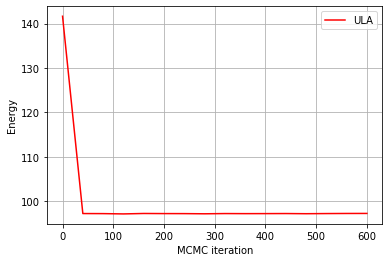

In [18]:
plt.plot([i*40 for i in range(len(ula_mean))], ula_mean, label = "ULA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel("Energy")
plt.grid()
plt.legend()
plt.show()

In [9]:
def compute_sir_log_weights(x, target, proposal):
    return target(x) - proposal.log_prob(x)

def sir_independent_dynamics_update(z, target, proposal, n_steps, N):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]
    
    diff_history = []

    for _ in tqdm(range(n_steps)):
        z_sp.append(z)
        z_old = z.clone().detach()
        U = torch.randint(0, N, (batch_size,)).tolist()
        X = proposal.sample([batch_size, N])
        X[np.arange(batch_size), U, :] = z
        X_view = X.view(-1, z_dim)

        log_weight = compute_sir_log_weights(X_view, target, proposal)
        log_weight = log_weight.view(batch_size, N)
      
        max_logs = torch.max(log_weight, dim=1)[0][:, None]
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim=1)
        weight = weight/sum_weight[:, None]

        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()

        z = X[np.arange(batch_size), indices, :]
        z = z.data
        
        diff = float((torch.norm(z.clone() - z_old, dim = 1) < 1e-10).sum())/batch_size
        
        diff_history.append(diff)

    z_sp.append(z)
    return z_sp, diff_history

In [17]:
N = 10
n_steps = 1000
batch_size = 100

z_start = torch.randn(batch_size, G.z_dim).to(device)

z_sp, diff_history = sir_independent_dynamics_update(z_start, target_gan, proposal, n_steps, N)

100%|██████████| 1000/1000 [01:49<00:00,  9.09it/s]


In [18]:
every_step = 40
z_sp_every = z_sp[::every_step]

In [19]:
zs_numpy = np.stack([o.data.cpu().numpy() for o in z_sp_every], axis=0)

In [20]:
n = zs_numpy.shape[1]
batchsize = n
num_bs = n // batchsize

sir_mean, sir_std = report_energy(zs_numpy, target_energy, num_bs, batchsize, device)

 27%|██▋       | 7/26 [00:00<00:00, 68.36it/s]

iter = 0
number of energy samples = 100
mean = 142.65362548828125
std = 6.880403995513916
------------
iter = 1
number of energy samples = 100
mean = 142.21237182617188
std = 7.196822166442871
------------
iter = 2
number of energy samples = 100
mean = 141.5471954345703
std = 7.595225811004639
------------
iter = 3
number of energy samples = 100
mean = 142.44903564453125
std = 6.990432262420654
------------
iter = 4
number of energy samples = 100
mean = 141.21006774902344
std = 7.078188419342041
------------
iter = 5
number of energy samples = 100
mean = 142.25392150878906
std = 6.560608863830566
------------
iter = 6
number of energy samples = 100
mean = 141.63226318359375
std = 7.196898937225342
------------
iter = 7
number of energy samples = 100
mean = 141.30331420898438
std = 6.226741313934326
------------
iter = 8
number of energy samples = 100
mean = 141.5135498046875
std = 6.245516777038574
------------
iter = 9
number of energy samples = 100
mean = 140.62918090820312
std = 7.0

100%|██████████| 26/26 [00:00<00:00, 74.90it/s]

number of energy samples = 100
mean = 142.87010192871094
std = 7.299497604370117
------------
iter = 15
number of energy samples = 100
mean = 142.76808166503906
std = 6.977027893066406
------------
iter = 16
number of energy samples = 100
mean = 141.74533081054688
std = 6.402209281921387
------------
iter = 17
number of energy samples = 100
mean = 142.28387451171875
std = 7.1925578117370605
------------
iter = 18
number of energy samples = 100
mean = 141.6639404296875
std = 6.483904838562012
------------
iter = 19
number of energy samples = 100
mean = 142.0612030029297
std = 6.192787170410156
------------
iter = 20
number of energy samples = 100
mean = 139.86871337890625
std = 7.078773498535156
------------
iter = 21
number of energy samples = 100
mean = 141.99728393554688
std = 7.3609185218811035
------------
iter = 22
number of energy samples = 100
mean = 141.1507110595703
std = 7.108511924743652
------------
iter = 23
number of energy samples = 100
mean = 141.3657684326172
std = 6.9

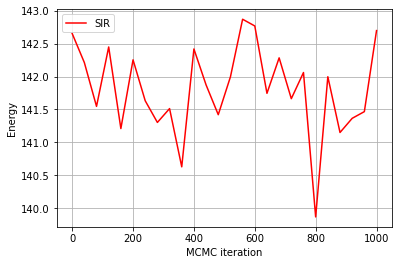

In [21]:
plt.plot([i*40 for i in range(len(sir_mean))], sir_mean, label = "SIR", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel("Energy")
plt.grid()
plt.legend()
plt.show()

In [21]:
z_sp[0].shape

torch.Size([200, 100])

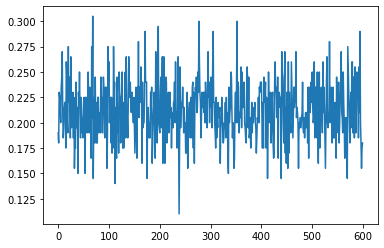

In [18]:
plt.plot([i for i in range(len(diff_history))], diff_history)
plt.show()

In [35]:
z = torch.randn(500, G.z_dim).to(device)
mean_discr = D(G(z)).sigmoid().mean()

In [36]:
mean_discr

tensor(0.5025, device='cuda:1', grad_fn=<MeanBackward0>)

In [22]:
z_transform = lambda x: x
use_sigmoid = True
mean_discr_val, std_discr_val = report_mean_discriminator(zs_numpy, G, D, z_transform, 
                                                          num_bs, batchsize, device, 
                                                          use_sigmoid=use_sigmoid)

 27%|██▋       | 7/26 [00:00<00:00, 65.71it/s]

iter = 0
number of energy samples = 100
mean = 0.49791276454925537
std = 0.057271558791399
------------
iter = 1
number of energy samples = 100
mean = 0.5345805883407593
std = 0.07661095261573792
------------
iter = 2
number of energy samples = 100
mean = 0.5261450409889221
std = 0.0674680843949318
------------
iter = 3
number of energy samples = 100
mean = 0.5254385471343994
std = 0.0749223604798317
------------
iter = 4
number of energy samples = 100
mean = 0.5280274748802185
std = 0.07519421726465225
------------
iter = 5
number of energy samples = 100
mean = 0.5345245599746704
std = 0.08111830055713654
------------
iter = 6
number of energy samples = 100
mean = 0.5246350765228271
std = 0.07662920653820038
------------
iter = 7
number of energy samples = 100
mean = 0.5220229625701904
std = 0.06153254956007004
------------
iter = 8
number of energy samples = 100
mean = 0.5237981081008911
std = 0.08061438798904419
------------
iter = 9
number of energy samples = 100
mean = 0.513520896

100%|██████████| 26/26 [00:00<00:00, 74.53it/s]

number of energy samples = 100
mean = 0.523982048034668
std = 0.07616845518350601
------------
iter = 15
number of energy samples = 100
mean = 0.5184056162834167
std = 0.07487516850233078
------------
iter = 16
number of energy samples = 100
mean = 0.5227597951889038
std = 0.06728874891996384
------------
iter = 17
number of energy samples = 100
mean = 0.5226198434829712
std = 0.07447654008865356
------------
iter = 18
number of energy samples = 100
mean = 0.5097423791885376
std = 0.05917210131883621
------------
iter = 19
number of energy samples = 100
mean = 0.521773099899292
std = 0.07422059774398804
------------
iter = 20
number of energy samples = 100
mean = 0.5207768082618713
std = 0.0769721269607544
------------
iter = 21
number of energy samples = 100
mean = 0.5236026644706726
std = 0.07151240855455399
------------
iter = 22
number of energy samples = 100
mean = 0.5165510773658752
std = 0.07129940390586853
------------
iter = 23
number of energy samples = 100
mean = 0.519224047

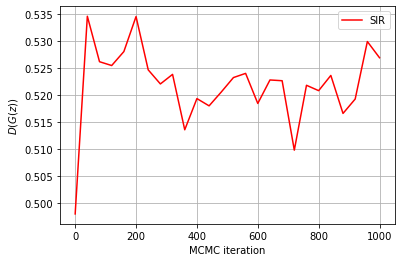

In [23]:
plt.plot([i*40 for i in range(len(mean_discr_val))], mean_discr_val, label = "SIR", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel(fr"$D(G(z))$")
plt.grid()
plt.legend()
plt.show()

In [27]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

N = 5

batch_size = 200
n = 1000
n_steps = 1001

grad_step = 5*0.01
eps_scale = (2 * grad_step) ** 0.5

method_name = 'sir_mala_sngan_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_N_{N}_nsteps_{n_steps}_step_{grad_step}_eps_{eps_scale}'
every_step = 40
continue_z = None

acceptance_rule = 'Hastings'

z_last_np, zs = sir_independent_mala_sampling(target_gan, proposal, batch_size, n,
                                              path_to_save, file_name, every_step,
                                              continue_z, n_steps, N, grad_step, eps_scale,
                                              acceptance_rule)

 20%|██        | 1/5 [03:41<14:44, 221.18s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_mala_sngan_cifar_recalc_N_5_nsteps_1001_step_0.05_eps_0.31622776601683794_batch_num_0.npy was saved, file shape = (26, 200, 100)


 40%|████      | 2/5 [07:26<11:07, 222.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_mala_sngan_cifar_recalc_N_5_nsteps_1001_step_0.05_eps_0.31622776601683794_batch_num_200.npy was saved, file shape = (26, 200, 100)


 60%|██████    | 3/5 [11:11<07:26, 223.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_mala_sngan_cifar_recalc_N_5_nsteps_1001_step_0.05_eps_0.31622776601683794_batch_num_400.npy was saved, file shape = (26, 200, 100)


 80%|████████  | 4/5 [14:56<03:43, 223.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_mala_sngan_cifar_recalc_N_5_nsteps_1001_step_0.05_eps_0.31622776601683794_batch_num_600.npy was saved, file shape = (26, 200, 100)


100%|██████████| 5/5 [18:41<00:00, 224.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_mala_sngan_cifar_recalc_N_5_nsteps_1001_step_0.05_eps_0.31622776601683794_batch_num_800.npy was saved, file shape = (26, 200, 100)


In [32]:
file_name

'sir_mala_sngan_cifar_recalc_N_5_nsteps_1001_step_0.05_eps_0.31622776601683794'

In [29]:
n = 1000
batchsize = 200
num_bs = n // batchsize

load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

100%|██████████| 5/5 [00:00<00:00, 1952.47it/s]


In [30]:
load_np.shape

(26, 1000, 100)

In [31]:
ula_mean, std_mean = report_energy(load_np, target_energy, num_bs, batchsize, device)

  4%|▍         | 1/26 [00:00<00:03,  7.18it/s]

iter = 0
number of energy samples = 1000
mean = 141.8033447265625
std = 6.694159030914307
------------
iter = 1


 12%|█▏        | 3/26 [00:00<00:02,  8.03it/s]

number of energy samples = 1000
mean = 142.43309020996094
std = 7.083502292633057
------------
iter = 2
number of energy samples = 1000
mean = 142.1190643310547
std = 7.034554958343506
------------
iter = 3


 19%|█▉        | 5/26 [00:00<00:02,  8.50it/s]

number of energy samples = 1000
mean = 141.87539672851562
std = 7.268433094024658
------------
iter = 4
number of energy samples = 1000
mean = 142.13311767578125
std = 7.011165618896484
------------
iter = 5


 27%|██▋       | 7/26 [00:00<00:02,  8.78it/s]

number of energy samples = 1000
mean = 141.85997009277344
std = 7.097349166870117
------------
iter = 6
number of energy samples = 1000
mean = 141.88490295410156
std = 7.0243096351623535
------------
iter = 7


 35%|███▍      | 9/26 [00:01<00:01,  8.91it/s]

number of energy samples = 1000
mean = 141.84353637695312
std = 6.883825778961182
------------
iter = 8
number of energy samples = 1000
mean = 141.86679077148438
std = 7.204814910888672
------------
iter = 9


 42%|████▏     | 11/26 [00:01<00:01,  8.95it/s]

number of energy samples = 1000
mean = 141.8322296142578
std = 6.8947930335998535
------------
iter = 10
number of energy samples = 1000
mean = 141.66119384765625
std = 6.898343563079834
------------
iter = 11


 50%|█████     | 13/26 [00:01<00:01,  9.01it/s]

number of energy samples = 1000
mean = 141.48239135742188
std = 7.070368766784668
------------
iter = 12
number of energy samples = 1000
mean = 142.00393676757812
std = 7.1501665115356445
------------
iter = 13


 58%|█████▊    | 15/26 [00:01<00:01,  9.03it/s]

number of energy samples = 1000
mean = 142.07205200195312
std = 6.917758464813232
------------
iter = 14
number of energy samples = 1000
mean = 141.85916137695312
std = 7.350790023803711
------------
iter = 15


 65%|██████▌   | 17/26 [00:01<00:00,  9.04it/s]

number of energy samples = 1000
mean = 141.98532104492188
std = 7.096488952636719
------------
iter = 16
number of energy samples = 1000
mean = 141.97560119628906
std = 7.031350612640381
------------
iter = 17


 73%|███████▎  | 19/26 [00:02<00:00,  9.03it/s]

number of energy samples = 1000
mean = 142.17367553710938
std = 7.163242340087891
------------
iter = 18
number of energy samples = 1000
mean = 141.8199005126953
std = 7.352567672729492
------------
iter = 19


 81%|████████  | 21/26 [00:02<00:00,  9.02it/s]

number of energy samples = 1000
mean = 141.56259155273438
std = 6.947989463806152
------------
iter = 20
number of energy samples = 1000
mean = 142.04200744628906
std = 7.206571102142334
------------
iter = 21


 88%|████████▊ | 23/26 [00:02<00:00,  9.03it/s]

number of energy samples = 1000
mean = 141.832275390625
std = 7.1343183517456055
------------
iter = 22
number of energy samples = 1000
mean = 141.78366088867188
std = 6.910483360290527
------------
iter = 23


 96%|█████████▌| 25/26 [00:02<00:00,  9.03it/s]

number of energy samples = 1000
mean = 141.68736267089844
std = 6.924605369567871
------------
iter = 24
number of energy samples = 1000
mean = 141.4935302734375
std = 6.807049751281738
------------
iter = 25


100%|██████████| 26/26 [00:02<00:00,  8.95it/s]

number of energy samples = 1000
mean = 141.91903686523438
std = 6.899006366729736
------------


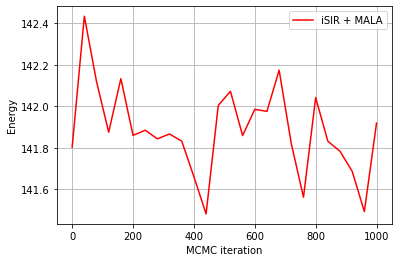

In [33]:
plt.plot([i*40 for i in range(len(ula_mean))], ula_mean, label = "iSIR + MALA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel("Energy")
plt.grid()
plt.legend()
plt.show()

In [34]:
z_transform = lambda x: x
use_sigmoid = True
mean_discr_val, std_discr_val = report_mean_discriminator(load_np, G, D, z_transform, 
                                                          num_bs, batchsize, device, 
                                                          use_sigmoid=use_sigmoid)

  4%|▍         | 1/26 [00:00<00:03,  7.13it/s]

iter = 0
number of energy samples = 1000
mean = 0.5041038393974304
std = 0.06608827412128448
------------
iter = 1


 12%|█▏        | 3/26 [00:00<00:02,  7.72it/s]

number of energy samples = 1000
mean = 0.5249201059341431
std = 0.07047873735427856
------------
iter = 2
number of energy samples = 1000
mean = 0.5217381715774536
std = 0.07236867398023605
------------
iter = 3


 19%|█▉        | 5/26 [00:00<00:02,  8.36it/s]

number of energy samples = 1000
mean = 0.5243805050849915
std = 0.07107419520616531
------------
iter = 4
number of energy samples = 1000
mean = 0.5256251692771912
std = 0.07420669496059418
------------
iter = 5


 27%|██▋       | 7/26 [00:00<00:02,  8.72it/s]

number of energy samples = 1000
mean = 0.5232337713241577
std = 0.07014378160238266
------------
iter = 6
number of energy samples = 1000
mean = 0.5206449627876282
std = 0.07075876742601395
------------
iter = 7


 35%|███▍      | 9/26 [00:01<00:01,  8.90it/s]

number of energy samples = 1000
mean = 0.5237534046173096
std = 0.07589522749185562
------------
iter = 8
number of energy samples = 1000
mean = 0.5231807827949524
std = 0.0753108412027359
------------
iter = 9


 42%|████▏     | 11/26 [00:01<00:01,  9.00it/s]

number of energy samples = 1000
mean = 0.5234870314598083
std = 0.07178564369678497
------------
iter = 10
number of energy samples = 1000
mean = 0.524114191532135
std = 0.0730430856347084
------------
iter = 11


 50%|█████     | 13/26 [00:01<00:01,  9.04it/s]

number of energy samples = 1000
mean = 0.5223708152770996
std = 0.0711960718035698
------------
iter = 12
number of energy samples = 1000
mean = 0.5210859179496765
std = 0.06688306480646133
------------
iter = 13


 58%|█████▊    | 15/26 [00:01<00:01,  9.06it/s]

number of energy samples = 1000
mean = 0.5240595936775208
std = 0.0710546001791954
------------
iter = 14
number of energy samples = 1000
mean = 0.5204179883003235
std = 0.07407819479703903
------------
iter = 15


 65%|██████▌   | 17/26 [00:01<00:00,  9.07it/s]

number of energy samples = 1000
mean = 0.5234183669090271
std = 0.0673089399933815
------------
iter = 16
number of energy samples = 1000
mean = 0.5207682847976685
std = 0.07185579091310501
------------
iter = 17


 73%|███████▎  | 19/26 [00:02<00:00,  9.09it/s]

number of energy samples = 1000
mean = 0.5215206146240234
std = 0.07316987961530685
------------
iter = 18
number of energy samples = 1000
mean = 0.5198888778686523
std = 0.07033386826515198
------------
iter = 19


 81%|████████  | 21/26 [00:02<00:00,  9.07it/s]

number of energy samples = 1000
mean = 0.5229529738426208
std = 0.07305765151977539
------------
iter = 20
number of energy samples = 1000
mean = 0.5258805155754089
std = 0.06958458572626114
------------
iter = 21


 88%|████████▊ | 23/26 [00:02<00:00,  9.07it/s]

number of energy samples = 1000
mean = 0.5167276263237
std = 0.06852790713310242
------------
iter = 22
number of energy samples = 1000
mean = 0.5247446298599243
std = 0.07693198323249817
------------
iter = 23


 96%|█████████▌| 25/26 [00:02<00:00,  9.06it/s]

number of energy samples = 1000
mean = 0.5211470127105713
std = 0.0708441510796547
------------
iter = 24
number of energy samples = 1000
mean = 0.51961350440979
std = 0.07354991883039474
------------
iter = 25


100%|██████████| 26/26 [00:02<00:00,  8.92it/s]

number of energy samples = 1000
mean = 0.5268630385398865
std = 0.07193891704082489
------------


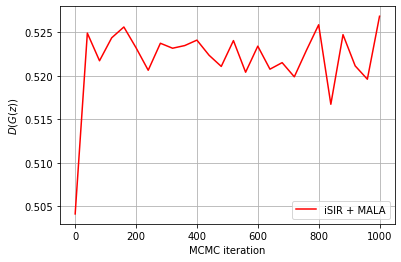

In [35]:
plt.plot([i*40 for i in range(len(mean_discr_val))], mean_discr_val, label = "iSIR + MALA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel(fr"$D(G(z))$")
plt.grid()
plt.legend()
plt.show()

## ResNet model

In [5]:
FLAGS = easydict.EasyDict({
    'arch': 'res32',
    'z_dim': 128
})

path_to_sngan = os.path.join(models_cifar_scratch_path, "model_resnet.pt")

In [6]:
args.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = args.device

G = net_G_models[FLAGS.arch](FLAGS.z_dim).to(device)

G.load_state_dict(torch.load(path_to_sngan)['net_G'])
G.eval()

ResGenerator32(
  (linear): Linear(in_features=128, out_features=4096, bias=True)
  (blocks): Sequential(
    (0): ResGenBlock(
      (residual): Sequential(
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Upsample(scale_factor=2.0, mode=nearest)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (shortcut): Sequential(
        (0): Upsample(scale_factor=2.0, mode=nearest)
        (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ResGenBlock(
      (residual): Sequential(
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Upsample(scale_factor=2.0, mode=nearest)
       

In [7]:
D = net_D_models[FLAGS.arch]().to(device)

D.load_state_dict(torch.load(path_to_sngan)['net_D'])
D.eval()

ResDiscriminator32(
  (model): Sequential(
    (0): OptimizedResDisblock(
      (shortcut): Sequential(
        (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (1): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (residual): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
    )
    (1): ResDisBlock(
      (shortcut): Sequential(
        (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (residual): Sequential(
        (0): ReLU()
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )


In [8]:
G.z_dim = FLAGS.z_dim
G.device = device
z_dim = FLAGS.z_dim

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True

target_gan = partial(gan_energy,
                     generator=G,
                     discriminator=D,
                     proposal=proposal,
                     normalize_to_0_1=normalize_to_0_1,
                     log_prob=log_prob)

log_prob = False
normalize_to_0_1 = True
target_energy = partial(gan_energy,
                         generator = G, 
                         discriminator = D, 
                         proposal = proposal,
                         normalize_to_0_1 = normalize_to_0_1,
                         log_prob = log_prob)

In [9]:
bs = 100
batch = torch.randn(bs, z_dim).to(device)
scores = D(G(batch)).sigmoid().mean()

In [14]:
scores_std = D(G(batch)).sigmoid().std()

In [15]:
scores_std

tensor(0.1538, device='cuda:1', grad_fn=<StdBackward0>)

In [10]:
scores

tensor(0.3516, device='cuda:1', grad_fn=<MeanBackward0>)

In [24]:
vals = []
bs = 10
for i in range(100):
    batch = torch.randn(bs, z_dim).to(device)
    scores = float(D(G(batch)).sigmoid().mean().cpu())
    vals.append(scores)
vals = np.array(vals)
print(np.mean(vals))

0.36517892867326734


In [22]:
vals

array([tensor(0.4016, grad_fn=<CopyBackwards>),
       tensor(0.3326, grad_fn=<CopyBackwards>),
       tensor(0.3609, grad_fn=<CopyBackwards>),
       tensor(0.3858, grad_fn=<CopyBackwards>),
       tensor(0.3516, grad_fn=<CopyBackwards>),
       tensor(0.3369, grad_fn=<CopyBackwards>),
       tensor(0.3501, grad_fn=<CopyBackwards>),
       tensor(0.3812, grad_fn=<CopyBackwards>),
       tensor(0.3309, grad_fn=<CopyBackwards>),
       tensor(0.3396, grad_fn=<CopyBackwards>)], dtype=object)

In [9]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 200
n = 1000
n_steps = 601

grad_step = 0.01
eps_scale = (2 * grad_step) ** 0.5

use_noise = True

method_name = 'ula_sngan_resnet_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_nsteps_{n_steps}_step_{grad_step}_eps_{eps_scale}_use_noise_{use_noise}'
every_step = 40
continue_z = None

In [12]:
z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z, n_steps, grad_step, eps_scale,
                                  use_noise)

 20%|██        | 1/5 [01:30<06:00, 90.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_0.npy was saved, file shape = (16, 200, 128)


 40%|████      | 2/5 [03:03<04:33, 91.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_200.npy was saved, file shape = (16, 200, 128)


 60%|██████    | 3/5 [04:37<03:04, 92.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_400.npy was saved, file shape = (16, 200, 128)


 80%|████████  | 4/5 [06:11<01:32, 92.51s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_600.npy was saved, file shape = (16, 200, 128)


100%|██████████| 5/5 [07:44<00:00, 92.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.01_eps_0.1414213562373095_use_noise_True_batch_num_800.npy was saved, file shape = (16, 200, 128)


In [10]:
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

n = 1000
batchsize = 200
num_bs = n // batchsize

100%|██████████| 5/5 [00:00<00:00, 2327.58it/s]


In [11]:
ula_mean, std_mean = report_energy(load_np, target_energy, num_bs, batchsize, device)

  0%|          | 0/16 [00:00<?, ?it/s]

iter = 0


  6%|▋         | 1/16 [00:00<00:03,  3.94it/s]

number of energy samples = 1000
mean = 182.0405731201172
std = 7.9649248123168945
------------
iter = 1


 12%|█▎        | 2/16 [00:00<00:03,  4.07it/s]

number of energy samples = 1000
mean = 182.05592346191406
std = 7.927347660064697
------------
iter = 2


 19%|█▉        | 3/16 [00:00<00:03,  4.17it/s]

number of energy samples = 1000
mean = 181.9185791015625
std = 8.552526473999023
------------
iter = 3


 25%|██▌       | 4/16 [00:00<00:02,  4.25it/s]

number of energy samples = 1000
mean = 181.93862915039062
std = 9.2759428024292
------------
iter = 4


 31%|███▏      | 5/16 [00:01<00:02,  4.30it/s]

number of energy samples = 1000
mean = 181.93453979492188
std = 9.938654899597168
------------
iter = 5


 38%|███▊      | 6/16 [00:01<00:02,  4.34it/s]

number of energy samples = 1000
mean = 181.4986572265625
std = 10.87387752532959
------------
iter = 6


 44%|████▍     | 7/16 [00:01<00:02,  4.37it/s]

number of energy samples = 1000
mean = 181.16709899902344
std = 11.656503677368164
------------
iter = 7


 50%|█████     | 8/16 [00:01<00:01,  4.39it/s]

number of energy samples = 1000
mean = 181.25584411621094
std = 11.545740127563477
------------
iter = 8


 56%|█████▋    | 9/16 [00:02<00:01,  4.40it/s]

number of energy samples = 1000
mean = 181.3070068359375
std = 11.50631332397461
------------
iter = 9


 62%|██████▎   | 10/16 [00:02<00:01,  4.41it/s]

number of energy samples = 1000
mean = 181.63345336914062
std = 12.376481056213379
------------
iter = 10


 69%|██████▉   | 11/16 [00:02<00:01,  4.41it/s]

number of energy samples = 1000
mean = 181.12815856933594
std = 12.23648738861084
------------
iter = 11


 75%|███████▌  | 12/16 [00:02<00:00,  4.42it/s]

number of energy samples = 1000
mean = 181.2940673828125
std = 12.578226089477539
------------
iter = 12


 81%|████████▏ | 13/16 [00:02<00:00,  4.42it/s]

number of energy samples = 1000
mean = 180.72409057617188
std = 12.389888763427734
------------
iter = 13


 88%|████████▊ | 14/16 [00:03<00:00,  4.42it/s]

number of energy samples = 1000
mean = 180.70797729492188
std = 12.959146499633789
------------
iter = 14


 94%|█████████▍| 15/16 [00:03<00:00,  4.42it/s]

number of energy samples = 1000
mean = 180.37779235839844
std = 14.272703170776367
------------
iter = 15


100%|██████████| 16/16 [00:03<00:00,  4.39it/s]

number of energy samples = 1000
mean = 180.3560333251953
std = 14.381941795349121
------------


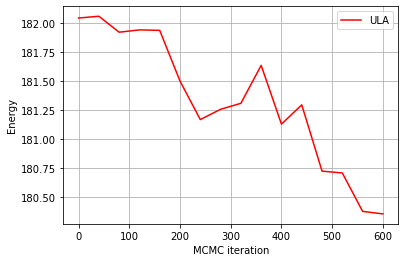

In [12]:
plt.plot([i*40 for i in range(len(ula_mean))], ula_mean, label = "ULA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel("Energy")
plt.grid()
plt.legend()
plt.show()

In [13]:
z_transform = lambda x: x
use_sigmoid = True
mean_discr_val, std_discr_val = report_mean_discriminator(load_np, G, D, z_transform, 
                                                          num_bs, batchsize, device, 
                                                          use_sigmoid=use_sigmoid)

  0%|          | 0/16 [00:00<?, ?it/s]

iter = 0


  6%|▋         | 1/16 [00:00<00:03,  4.00it/s]

number of energy samples = 1000
mean = 0.37303319573402405
std = 0.16258041560649872
------------
iter = 1


 12%|█▎        | 2/16 [00:00<00:03,  4.13it/s]

number of energy samples = 1000
mean = 0.47867533564567566
std = 0.2021336704492569
------------
iter = 2


 19%|█▉        | 3/16 [00:00<00:03,  4.22it/s]

number of energy samples = 1000
mean = 0.4993061423301697
std = 0.21115876734256744
------------
iter = 3


 25%|██▌       | 4/16 [00:00<00:02,  4.28it/s]

number of energy samples = 1000
mean = 0.5012485980987549
std = 0.21942776441574097
------------
iter = 4


 31%|███▏      | 5/16 [00:01<00:02,  4.33it/s]

number of energy samples = 1000
mean = 0.5107355117797852
std = 0.22625155746936798
------------
iter = 5


 38%|███▊      | 6/16 [00:01<00:02,  4.36it/s]

number of energy samples = 1000
mean = 0.5097720623016357
std = 0.22910331189632416
------------
iter = 6


 44%|████▍     | 7/16 [00:01<00:02,  4.39it/s]

number of energy samples = 1000
mean = 0.5265235304832458
std = 0.2295800894498825
------------
iter = 7


 50%|█████     | 8/16 [00:01<00:01,  4.41it/s]

number of energy samples = 1000
mean = 0.5350632071495056
std = 0.23756852746009827
------------
iter = 8


 56%|█████▋    | 9/16 [00:02<00:01,  4.42it/s]

number of energy samples = 1000
mean = 0.5206617712974548
std = 0.2328920066356659
------------
iter = 9


 62%|██████▎   | 10/16 [00:02<00:01,  4.42it/s]

number of energy samples = 1000
mean = 0.5279006361961365
std = 0.2375754415988922
------------
iter = 10


 69%|██████▉   | 11/16 [00:02<00:01,  4.43it/s]

number of energy samples = 1000
mean = 0.5346050262451172
std = 0.23683594167232513
------------
iter = 11


 75%|███████▌  | 12/16 [00:02<00:00,  4.43it/s]

number of energy samples = 1000
mean = 0.5314851999282837
std = 0.2406153529882431
------------
iter = 12


 81%|████████▏ | 13/16 [00:02<00:00,  4.43it/s]

number of energy samples = 1000
mean = 0.5403496026992798
std = 0.24606534838676453
------------
iter = 13


 88%|████████▊ | 14/16 [00:03<00:00,  4.43it/s]

number of energy samples = 1000
mean = 0.5611893534660339
std = 0.25024962425231934
------------
iter = 14


 94%|█████████▍| 15/16 [00:03<00:00,  4.43it/s]

number of energy samples = 1000
mean = 0.5473260879516602
std = 0.2464061826467514
------------
iter = 15


100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

number of energy samples = 1000
mean = 0.5583806037902832
std = 0.24921204149723053
------------


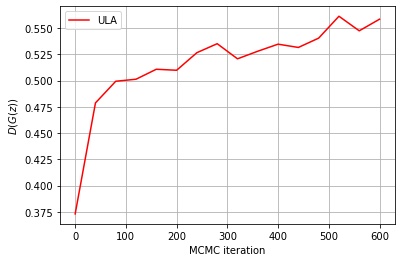

In [14]:
plt.plot([i*40 for i in range(len(mean_discr_val))], mean_discr_val, label = "ULA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel(r"$D(G(z))$")
plt.grid()
plt.legend()
plt.show()

In [11]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 200
n = 1000
n_steps = 601

grad_step = 0.1
eps_scale = (2 * grad_step) ** 0.5

use_noise = True

method_name = 'ula_sngan_resnet_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_nsteps_{n_steps}_step_{grad_step}_eps_{eps_scale}_use_noise_{use_noise}'
every_step = 40
continue_z = None

In [17]:
z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z, n_steps, grad_step, eps_scale,
                                  use_noise)

 20%|██        | 1/5 [01:30<06:01, 90.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.1_eps_0.4472135954999579_use_noise_True_batch_num_0.npy was saved, file shape = (16, 200, 128)


 40%|████      | 2/5 [03:03<04:33, 91.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.1_eps_0.4472135954999579_use_noise_True_batch_num_200.npy was saved, file shape = (16, 200, 128)


 60%|██████    | 3/5 [04:37<03:04, 92.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.1_eps_0.4472135954999579_use_noise_True_batch_num_400.npy was saved, file shape = (16, 200, 128)


 80%|████████  | 4/5 [06:11<01:32, 92.51s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.1_eps_0.4472135954999579_use_noise_True_batch_num_600.npy was saved, file shape = (16, 200, 128)


100%|██████████| 5/5 [07:44<00:00, 92.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.1_eps_0.4472135954999579_use_noise_True_batch_num_800.npy was saved, file shape = (16, 200, 128)


In [12]:
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

n = 1000
batchsize = 200
num_bs = n // batchsize

100%|██████████| 5/5 [00:00<00:00, 2321.91it/s]


In [13]:
ula_mean, std_mean = report_energy(load_np, target_energy, num_bs, batchsize, device)

  0%|          | 0/16 [00:00<?, ?it/s]

iter = 0


  6%|▋         | 1/16 [00:00<00:03,  3.91it/s]

number of energy samples = 1000
mean = 182.0405731201172
std = 7.9649248123168945
------------
iter = 1


 12%|█▎        | 2/16 [00:00<00:03,  4.05it/s]

number of energy samples = 1000
mean = 186.4396514892578
std = 9.202497482299805
------------
iter = 2


 19%|█▉        | 3/16 [00:00<00:03,  4.15it/s]

number of energy samples = 1000
mean = 186.93809509277344
std = 8.697590827941895
------------
iter = 3


 25%|██▌       | 4/16 [00:00<00:02,  4.22it/s]

number of energy samples = 1000
mean = 186.06588745117188
std = 8.73275089263916
------------
iter = 4


 31%|███▏      | 5/16 [00:01<00:02,  4.28it/s]

number of energy samples = 1000
mean = 186.62841796875
std = 8.803828239440918
------------
iter = 5


 38%|███▊      | 6/16 [00:01<00:02,  4.31it/s]

number of energy samples = 1000
mean = 186.10885620117188
std = 8.693658828735352
------------
iter = 6


 44%|████▍     | 7/16 [00:01<00:02,  4.34it/s]

number of energy samples = 1000
mean = 186.23533630371094
std = 8.860313415527344
------------
iter = 7


 50%|█████     | 8/16 [00:01<00:01,  4.36it/s]

number of energy samples = 1000
mean = 185.83706665039062
std = 8.952540397644043
------------
iter = 8


 56%|█████▋    | 9/16 [00:02<00:01,  4.37it/s]

number of energy samples = 1000
mean = 186.71498107910156
std = 8.604625701904297
------------
iter = 9


 62%|██████▎   | 10/16 [00:02<00:01,  4.38it/s]

number of energy samples = 1000
mean = 186.22683715820312
std = 8.730008125305176
------------
iter = 10


 69%|██████▉   | 11/16 [00:02<00:01,  4.39it/s]

number of energy samples = 1000
mean = 186.62925720214844
std = 8.991918563842773
------------
iter = 11


 75%|███████▌  | 12/16 [00:02<00:00,  4.39it/s]

number of energy samples = 1000
mean = 186.325439453125
std = 9.201945304870605
------------
iter = 12


 81%|████████▏ | 13/16 [00:02<00:00,  4.39it/s]

number of energy samples = 1000
mean = 186.23094177246094
std = 9.638032913208008
------------
iter = 13


 88%|████████▊ | 14/16 [00:03<00:00,  4.40it/s]

number of energy samples = 1000
mean = 185.8953094482422
std = 9.2650728225708
------------
iter = 14


 94%|█████████▍| 15/16 [00:03<00:00,  4.40it/s]

number of energy samples = 1000
mean = 186.3158721923828
std = 9.415365219116211
------------
iter = 15


100%|██████████| 16/16 [00:03<00:00,  4.37it/s]

number of energy samples = 1000
mean = 186.14047241210938
std = 9.524237632751465
------------


In [9]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 200
n = 1000
n_steps = 601

grad_step = 0.001
eps_scale = (2 * grad_step) ** 0.5

use_noise = True

method_name = 'ula_sngan_resnet_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_nsteps_{n_steps}_step_{grad_step}_eps_{eps_scale}_use_noise_{use_noise}'
every_step = 40
continue_z = None

In [10]:
z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z, n_steps, grad_step, eps_scale,
                                  use_noise)

 20%|██        | 1/5 [01:30<06:01, 90.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.001_eps_0.044721359549995794_use_noise_True_batch_num_0.npy was saved, file shape = (16, 200, 128)


 40%|████      | 2/5 [03:03<04:33, 91.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.001_eps_0.044721359549995794_use_noise_True_batch_num_200.npy was saved, file shape = (16, 200, 128)


 60%|██████    | 3/5 [04:37<03:04, 92.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.001_eps_0.044721359549995794_use_noise_True_batch_num_400.npy was saved, file shape = (16, 200, 128)


 80%|████████  | 4/5 [06:11<01:32, 92.49s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.001_eps_0.044721359549995794_use_noise_True_batch_num_600.npy was saved, file shape = (16, 200, 128)


100%|██████████| 5/5 [07:44<00:00, 92.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.001_eps_0.044721359549995794_use_noise_True_batch_num_800.npy was saved, file shape = (16, 200, 128)


In [11]:
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

n = 1000
batchsize = 200
num_bs = n // batchsize

100%|██████████| 5/5 [00:00<00:00, 2537.39it/s]


In [12]:
ula_mean, std_mean = report_energy(load_np, target_energy, num_bs, batchsize, device)

  0%|          | 0/16 [00:00<?, ?it/s]

iter = 0


  6%|▋         | 1/16 [00:00<00:03,  4.31it/s]

number of energy samples = 1000
mean = 182.0405731201172
std = 7.9649248123168945
------------
iter = 1


 12%|█▎        | 2/16 [00:00<00:03,  4.29it/s]

number of energy samples = 1000
mean = 181.80633544921875
std = 7.921615123748779
------------
iter = 2


 19%|█▉        | 3/16 [00:00<00:03,  4.27it/s]

number of energy samples = 1000
mean = 181.62657165527344
std = 7.813420295715332
------------
iter = 3


 25%|██▌       | 4/16 [00:00<00:02,  4.25it/s]

number of energy samples = 1000
mean = 181.6621856689453
std = 7.81403923034668
------------
iter = 4


 31%|███▏      | 5/16 [00:01<00:02,  4.24it/s]

number of energy samples = 1000
mean = 181.5923614501953
std = 7.900378227233887
------------
iter = 5


 38%|███▊      | 6/16 [00:01<00:02,  4.24it/s]

number of energy samples = 1000
mean = 181.5580596923828
std = 8.048165321350098
------------
iter = 6


 44%|████▍     | 7/16 [00:01<00:02,  4.23it/s]

number of energy samples = 1000
mean = 181.52996826171875
std = 8.062662124633789
------------
iter = 7


 50%|█████     | 8/16 [00:01<00:01,  4.23it/s]

number of energy samples = 1000
mean = 181.3973846435547
std = 7.988422870635986
------------
iter = 8


 56%|█████▋    | 9/16 [00:02<00:01,  4.23it/s]

number of energy samples = 1000
mean = 181.37332153320312
std = 8.013983726501465
------------
iter = 9


 62%|██████▎   | 10/16 [00:02<00:01,  4.22it/s]

number of energy samples = 1000
mean = 181.64471435546875
std = 8.213239669799805
------------
iter = 10


 69%|██████▉   | 11/16 [00:02<00:01,  4.22it/s]

number of energy samples = 1000
mean = 181.43902587890625
std = 8.6331148147583
------------
iter = 11


 75%|███████▌  | 12/16 [00:02<00:00,  4.22it/s]

number of energy samples = 1000
mean = 181.48358154296875
std = 8.8270902633667
------------
iter = 12


 81%|████████▏ | 13/16 [00:03<00:00,  4.22it/s]

number of energy samples = 1000
mean = 181.358154296875
std = 8.872788429260254
------------
iter = 13


 88%|████████▊ | 14/16 [00:03<00:00,  4.22it/s]

number of energy samples = 1000
mean = 181.5653076171875
std = 8.770751953125
------------
iter = 14


 94%|█████████▍| 15/16 [00:03<00:00,  4.22it/s]

number of energy samples = 1000
mean = 181.67459106445312
std = 8.790871620178223
------------
iter = 15


100%|██████████| 16/16 [00:03<00:00,  4.22it/s]

number of energy samples = 1000
mean = 181.65872192382812
std = 8.679335594177246
------------


In [26]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 200
n = 1000
n_steps = 601

grad_step = 0.05
eps_scale = (2 * grad_step) ** 0.5

use_noise = True

method_name = 'ula_sngan_resnet_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_nsteps_{n_steps}_step_{grad_step}_eps_{eps_scale}_use_noise_{use_noise}'
every_step = 40
continue_z = None

In [16]:
z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z, n_steps, grad_step, eps_scale,
                                  use_noise)

 20%|██        | 1/5 [01:30<06:01, 90.44s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.05_eps_0.31622776601683794_use_noise_True_batch_num_0.npy was saved, file shape = (16, 200, 128)


 40%|████      | 2/5 [03:03<04:34, 91.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.05_eps_0.31622776601683794_use_noise_True_batch_num_200.npy was saved, file shape = (16, 200, 128)


 60%|██████    | 3/5 [04:37<03:04, 92.09s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.05_eps_0.31622776601683794_use_noise_True_batch_num_400.npy was saved, file shape = (16, 200, 128)


 80%|████████  | 4/5 [06:11<01:32, 92.53s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.05_eps_0.31622776601683794_use_noise_True_batch_num_600.npy was saved, file shape = (16, 200, 128)


100%|██████████| 5/5 [07:44<00:00, 92.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.05_eps_0.31622776601683794_use_noise_True_batch_num_800.npy was saved, file shape = (16, 200, 128)


In [27]:
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

n = 1000
batchsize = 200
num_bs = n // batchsize

100%|██████████| 5/5 [00:00<00:00, 2523.04it/s]


In [28]:
ula_mean, std_mean = report_energy(load_np, target_energy, num_bs, batchsize, device)

  0%|          | 0/16 [00:00<?, ?it/s]

iter = 0


  6%|▋         | 1/16 [00:00<00:03,  3.98it/s]

number of energy samples = 1000
mean = 182.0405731201172
std = 7.9649248123168945
------------
iter = 1


 12%|█▎        | 2/16 [00:00<00:03,  4.10it/s]

number of energy samples = 1000
mean = 183.58937072753906
std = 9.461840629577637
------------
iter = 2


 19%|█▉        | 3/16 [00:00<00:03,  4.20it/s]

number of energy samples = 1000
mean = 183.87709045410156
std = 10.478273391723633
------------
iter = 3


 25%|██▌       | 4/16 [00:00<00:02,  4.26it/s]

number of energy samples = 1000
mean = 183.1565399169922
std = 11.0250244140625
------------
iter = 4


 31%|███▏      | 5/16 [00:01<00:02,  4.31it/s]

number of energy samples = 1000
mean = 183.40248107910156
std = 11.381664276123047
------------
iter = 5


 38%|███▊      | 6/16 [00:01<00:02,  4.35it/s]

number of energy samples = 1000
mean = 182.34979248046875
std = 13.100394248962402
------------
iter = 6


 44%|████▍     | 7/16 [00:01<00:02,  4.37it/s]

number of energy samples = 1000
mean = 182.3652801513672
std = 12.30479621887207
------------
iter = 7


 50%|█████     | 8/16 [00:01<00:01,  4.39it/s]

number of energy samples = 1000
mean = 182.45858764648438
std = 13.6621732711792
------------
iter = 8


 56%|█████▋    | 9/16 [00:02<00:01,  4.40it/s]

number of energy samples = 1000
mean = 182.78050231933594
std = 12.184125900268555
------------
iter = 9


 62%|██████▎   | 10/16 [00:02<00:01,  4.41it/s]

number of energy samples = 1000
mean = 182.54278564453125
std = 12.816618919372559
------------
iter = 10


 69%|██████▉   | 11/16 [00:02<00:01,  4.42it/s]

number of energy samples = 1000
mean = 182.6037139892578
std = 14.482230186462402
------------
iter = 11


 75%|███████▌  | 12/16 [00:02<00:00,  4.42it/s]

number of energy samples = 1000
mean = 182.11737060546875
std = 13.203208923339844
------------
iter = 12


 81%|████████▏ | 13/16 [00:02<00:00,  4.42it/s]

number of energy samples = 1000
mean = 181.52590942382812
std = 14.363497734069824
------------
iter = 13


 88%|████████▊ | 14/16 [00:03<00:00,  4.42it/s]

number of energy samples = 1000
mean = 181.39727783203125
std = 14.346043586730957
------------
iter = 14


 94%|█████████▍| 15/16 [00:03<00:00,  4.42it/s]

number of energy samples = 1000
mean = 181.3743438720703
std = 15.095344543457031
------------
iter = 15


100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

number of energy samples = 1000
mean = 181.70831298828125
std = 14.451433181762695
------------


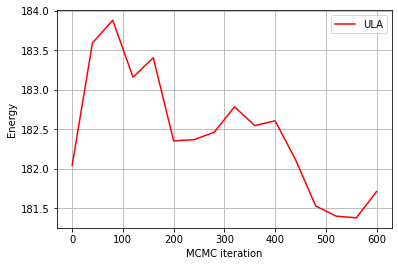

In [29]:
plt.plot([i*40 for i in range(len(ula_mean))], ula_mean, label = "ULA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel("Energy")
plt.grid()
plt.legend()
plt.show()

In [21]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 200
n = 1000
n_steps = 601

grad_step = 0.02
eps_scale = (2 * grad_step) ** 0.5

use_noise = True

method_name = 'ula_sngan_resnet_cifar_recalc'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_nsteps_{n_steps}_step_{grad_step}_eps_{eps_scale}_use_noise_{use_noise}'
every_step = 40
continue_z = None

In [22]:
z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z, n_steps, grad_step, eps_scale,
                                  use_noise)

 20%|██        | 1/5 [01:32<06:09, 92.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.02_eps_0.2_use_noise_True_batch_num_0.npy was saved, file shape = (16, 200, 128)


 40%|████      | 2/5 [03:05<04:38, 92.70s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.02_eps_0.2_use_noise_True_batch_num_200.npy was saved, file shape = (16, 200, 128)


 60%|██████    | 3/5 [04:39<03:05, 92.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.02_eps_0.2_use_noise_True_batch_num_400.npy was saved, file shape = (16, 200, 128)


 80%|████████  | 4/5 [06:12<01:33, 93.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.02_eps_0.2_use_noise_True_batch_num_600.npy was saved, file shape = (16, 200, 128)


100%|██████████| 5/5 [07:46<00:00, 93.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_sngan_resnet_cifar_recalc_nsteps_601_step_0.02_eps_0.2_use_noise_True_batch_num_800.npy was saved, file shape = (16, 200, 128)


In [23]:
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

n = 1000
batchsize = 200
num_bs = n // batchsize

100%|██████████| 5/5 [00:00<00:00, 2342.14it/s]


In [24]:
ula_mean, std_mean = report_energy(load_np, target_energy, num_bs, batchsize, device)

  0%|          | 0/16 [00:00<?, ?it/s]

iter = 0


  6%|▋         | 1/16 [00:00<00:03,  4.31it/s]

number of energy samples = 1000
mean = 182.0405731201172
std = 7.9649248123168945
------------
iter = 1


 12%|█▎        | 2/16 [00:00<00:03,  4.28it/s]

number of energy samples = 1000
mean = 182.4692840576172
std = 8.688170433044434
------------
iter = 2


 19%|█▉        | 3/16 [00:00<00:03,  4.26it/s]

number of energy samples = 1000
mean = 182.43136596679688
std = 8.8725004196167
------------
iter = 3


 25%|██▌       | 4/16 [00:00<00:02,  4.25it/s]

number of energy samples = 1000
mean = 181.798828125
std = 11.415973663330078
------------
iter = 4


 31%|███▏      | 5/16 [00:01<00:02,  4.24it/s]

number of energy samples = 1000
mean = 181.6396942138672
std = 12.661226272583008
------------
iter = 5


 38%|███▊      | 6/16 [00:01<00:02,  4.23it/s]

number of energy samples = 1000
mean = 180.7051544189453
std = 14.98609733581543
------------
iter = 6


 44%|████▍     | 7/16 [00:01<00:02,  4.23it/s]

number of energy samples = 1000
mean = 180.07115173339844
std = 16.304506301879883
------------
iter = 7


 50%|█████     | 8/16 [00:01<00:01,  4.23it/s]

number of energy samples = 1000
mean = 179.84609985351562
std = 17.237966537475586
------------
iter = 8


 56%|█████▋    | 9/16 [00:02<00:01,  4.23it/s]

number of energy samples = 1000
mean = 179.5710906982422
std = 17.454547882080078
------------
iter = 9


 62%|██████▎   | 10/16 [00:02<00:01,  4.22it/s]

number of energy samples = 1000
mean = 179.47032165527344
std = 18.919761657714844
------------
iter = 10


 69%|██████▉   | 11/16 [00:02<00:01,  4.21it/s]

number of energy samples = 1000
mean = 179.0347442626953
std = 19.004961013793945
------------
iter = 11


 75%|███████▌  | 12/16 [00:02<00:00,  4.21it/s]

number of energy samples = 1000
mean = 178.76808166503906
std = 19.609691619873047
------------
iter = 12


 81%|████████▏ | 13/16 [00:03<00:00,  4.21it/s]

number of energy samples = 1000
mean = 178.1132354736328
std = 20.04307746887207
------------
iter = 13


 88%|████████▊ | 14/16 [00:03<00:00,  4.21it/s]

number of energy samples = 1000
mean = 177.43394470214844
std = 21.621572494506836
------------
iter = 14


 94%|█████████▍| 15/16 [00:03<00:00,  4.21it/s]

number of energy samples = 1000
mean = 176.89247131347656
std = 22.306852340698242
------------
iter = 15


100%|██████████| 16/16 [00:03<00:00,  4.22it/s]

number of energy samples = 1000
mean = 176.4280242919922
std = 23.80924415588379
------------


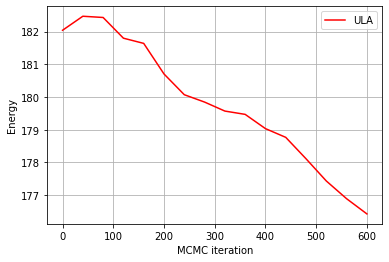

In [25]:
plt.plot([i*40 for i in range(len(ula_mean))], ula_mean, label = "ULA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel("Energy")
plt.grid()
plt.legend()
plt.show()

In [30]:
z_transform = lambda x: x
use_sigmoid = True
mean_discr_val, std_discr_val = report_mean_discriminator(load_np, G, D, z_transform, 
                                                          num_bs, batchsize, device, 
                                                          use_sigmoid=use_sigmoid)

  0%|          | 0/16 [00:00<?, ?it/s]

iter = 0


  6%|▋         | 1/16 [00:00<00:03,  4.06it/s]

number of energy samples = 1000
mean = 0.37303319573402405
std = 0.16258041560649872
------------
iter = 1


 12%|█▎        | 2/16 [00:00<00:03,  4.17it/s]

number of energy samples = 1000
mean = 0.46355530619621277
std = 0.2121623456478119
------------
iter = 2


 19%|█▉        | 3/16 [00:00<00:03,  4.25it/s]

number of energy samples = 1000
mean = 0.4656195044517517
std = 0.22112351655960083
------------
iter = 3


 25%|██▌       | 4/16 [00:00<00:02,  4.30it/s]

number of energy samples = 1000
mean = 0.4707905352115631
std = 0.22948096692562103
------------
iter = 4


 31%|███▏      | 5/16 [00:01<00:02,  4.35it/s]

number of energy samples = 1000
mean = 0.4857109785079956
std = 0.2373926043510437
------------
iter = 5


 38%|███▊      | 6/16 [00:01<00:02,  4.38it/s]

number of energy samples = 1000
mean = 0.4787008464336395
std = 0.2385280579328537
------------
iter = 6


 44%|████▍     | 7/16 [00:01<00:02,  4.40it/s]

number of energy samples = 1000
mean = 0.48142412304878235
std = 0.24009625613689423
------------
iter = 7


 50%|█████     | 8/16 [00:01<00:01,  4.41it/s]

number of energy samples = 1000
mean = 0.49728935956954956
std = 0.23671028017997742
------------
iter = 8


 56%|█████▋    | 9/16 [00:02<00:01,  4.42it/s]

number of energy samples = 1000
mean = 0.4888124167919159
std = 0.24532167613506317
------------
iter = 9


 62%|██████▎   | 10/16 [00:02<00:01,  4.43it/s]

number of energy samples = 1000
mean = 0.4933492839336395
std = 0.2424742728471756
------------
iter = 10


 69%|██████▉   | 11/16 [00:02<00:01,  4.43it/s]

number of energy samples = 1000
mean = 0.49675413966178894
std = 0.25156858563423157
------------
iter = 11


 75%|███████▌  | 12/16 [00:02<00:00,  4.44it/s]

number of energy samples = 1000
mean = 0.510517954826355
std = 0.249176487326622
------------
iter = 12


 81%|████████▏ | 13/16 [00:02<00:00,  4.44it/s]

number of energy samples = 1000
mean = 0.4964717924594879
std = 0.2502160668373108
------------
iter = 13


 88%|████████▊ | 14/16 [00:03<00:00,  4.44it/s]

number of energy samples = 1000
mean = 0.5182898640632629
std = 0.25742584466934204
------------
iter = 14


 94%|█████████▍| 15/16 [00:03<00:00,  4.44it/s]

number of energy samples = 1000
mean = 0.5114896893501282
std = 0.2578408420085907
------------
iter = 15


100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

number of energy samples = 1000
mean = 0.5223067998886108
std = 0.2598976194858551
------------


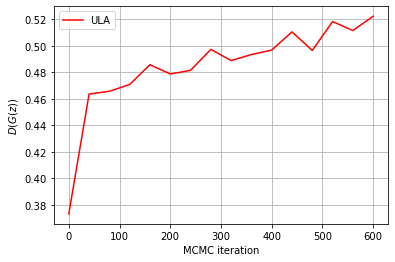

In [31]:
plt.plot([i*40 for i in range(len(mean_discr_val))], mean_discr_val, label = "ULA", color='r')
plt.xlabel("MCMC iteration")
plt.ylabel(r"$D(G(z))$")
plt.grid()
plt.legend()
plt.show()

In [11]:
N = 5
n_steps = 601
batch_size = 50

diff_vals = []

for i in range(5):
    z_start = torch.randn(batch_size, G.z_dim).to(device)

    z_sp, diff_history = sir_independent_dynamics_update(z_start, target_gan, proposal, n_steps, N)
    diff_vals.append(diff_history)

  0%|          | 0/601 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 250.00 MiB (GPU 1; 10.76 GiB total capacity; 7.19 GiB already allocated; 50.75 MiB free; 7.30 GiB reserved in total by PyTorch)

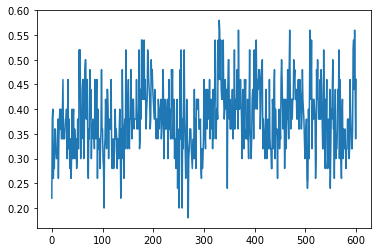

In [17]:
plt.plot([i for i in range(len(diff_history))], diff_history)
plt.show()